# Exercise 4 - Quantum Chemistry. Electronic Structure Calculations 


## Background

Quantum computing holds promise to revolutionize high-performance computing and possesses enormous potential for transforming various fields beyond the current capabilities of classical computing. Chemistry is one of the most promising applications of quantum computing. In particular, simulating the electronic structure of molecules to better understand chemical reactions and design new pharmaceutical drugs and materials, is one of the main near-term exciting applications for quantum computers.

The Variational Quantum Eigensolver (VQE) is the main workhorse algorithm for quantum chemistry using near-term quantum computers. It is a hybrid quantum-classical algorithm that is used to find the ground state energy (lowest energy) of a molecular system. The algorithm was first published in 2014 by Alberto Peruzzo and coworkers [1] and used by IBM Quantum to simulate the ground state energy of small molecules in 2017.[2] Obtaining the ground state energies allows us to understand and study chemical reactions and gain additional insignt into various molecular properties, for instance the exact forces on nuclei than can serve to run molecular dynamics simulations to explore what happens in chemical systems with time.[3]

VQE algorithm starts with a parameterized quantum circuit called an ansatz and a set of tunable parameters that get iteratively updated with a classical optimizers until the lowest energy is obtained. The VQE's advantage over classical algorithms comes from the fact that a quantum processing unit can represent and store the problem's wavefunction more efficiently than a classical computer. 

The quantum Equation Of Motion (qEOM) algorithm is an extension of the VQE to find the excitation energies (difference between ground and excited states energies, also called electronic transition energies) of the molecule. [4]

In this exercise you will simulate a water molecule using VQE and qEOM to calculate its ground and excited state energies with a variety of tools available in Qiskit Nature.


### References

1. Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." Nature communications 5.1 (2014): 1-7.
2. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246.
3. Sokolov, Igor O., et al. "Microcanonical and finite-temperature ab initio molecular dynamics simulations on quantum computers." Physical Review Research 3.1 (2021): 013125.
4. Ollitrault, Pauline J., et al. "Quantum equation of motion for computing molecular excitation energies on a noisy quantum processor." Physical Review Research 2.4 (2020): 043140.

In addition, a review on VQE: Cerezo, M., et al. "Variational quantum algorithms." Nat Rev Phys 3, 625–644 (2021). 

## Introduction

One of the most important tasks when running a VQE algorithm on a noisy quantum computer is to reduce the computational cost by minimizing the quantum resources (number of qubits, quantum gates and measurements). This in turn, minimizes the computational errors. The goal is to construct the most compact and optimal quantum circuit capable of representing the ground state accurately. 

<div class="alert alert-block alert-success">

<b>Goal</b> 

We will first learn how to define an electronic structure problem with Qiskit Nature. We will then find the most efficient ansatz for approximating the ground state of a water molecule. Finally, we will use the ground state results to perform excited states calculations. 
    
<b>Plan</b> 
        
**Part 1: VQE for water molecule :** familiarize yourself with VQE and select the best combination of ansatz/classical optimizer by running statevector simulations.

**Part 2: qEOM for water molecule :** extend the ground state calculation to find the electronic transition energies of this water molecule. Learn how to compare the quantum algorithm results with those obtained classically.

</div>


<div class="alert alert-block alert-danger">

Below is an introduction to the theory behind VQE simulations. You don't have to understand the whole thing before moving on. Don't be scared!

</div>



## Theory

### Quantum and Classical


Here is the general workflow representing how the molecular simulations using VQE are performed on quantum computers.

<img src="resources/workflow.png" width=600/>

The core idea behind a hybrid quantum-classical approach is to divide the task between **CPU (classical processing unit)** and **QPU (quantum processing unit)** based on what they can do best. The CPU takes care of listing the terms that need to be measured to compute the energy and also optimizing the circuit parameters. The QPU implements a quantum circuit representing the quantum state of a system and measures the energy.

For example, **CPU** can be used to find a set of functions (also called orbitals) which help re-expressing and simplifying the problem. In practice these orbitals are found through the [Hartree–Fock (HF) method](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method#:~:text=In%20computational%20physics%20and%20chemistry,system%20in%20a%20stationary%20state.). Further information on this method is provided below. 

After a HF calculation, the Hamiltonian is expressed in the basis of the resulting orbitals. It is then mapped to a qubit Hamiltonian using fermion-to-qubit transformations (see Hamiltonian section below). One can further analyze the properties of the system to reduce the number of qubits or shorten the ansatz circuit:

- For Z2 symmetries and two-qubit reduction, see [Bravyi *et al*, 2017](https://arxiv.org/abs/1701.08213v1).
- For entanglement forging, see [Eddins *et al.*, 2021](https://arxiv.org/abs/2104.10220v1).
- For the adaptive ansatz see, [Grimsley *et al.*,2018](https://arxiv.org/abs/1812.11173v2), [Rattew *et al.*,2019](https://arxiv.org/abs/1910.09694), [Tang *et al.*,2019](https://arxiv.org/abs/1911.10205). You may use the ideas found in those works to find ways to shorten the quantum circuits.

**QPU** is employed to implements quantum circuits (see Ansatzes section below), parameterized by angles $\vec\theta$. The goal is to find the set of these angles which best approximate the exact ground state wavefunction (or in other words, that minimizes the energy). Expectation values of different operators can then be measured on the trial wavefucntion prepared in the QPU.

Below we go slightly more into mathematical details of each component of the VQE and qEOM algorithms. It might be also helpful if you watch our [video episode about VQE](https://www.youtube.com/watch?v=Z-A6G0WVI9w).


### Hartree-Fock

Hartree-Fock theory is based on the assumption that the many-electron wavefunction of the system can be described by a single Slater determinant made of one-electron molecular orbitals.  

Electrons are indistinguishable fermions. This means that any permutation of two electrons must change the sign of the wavefunction (this is a really important constraint called the Pauli exclusion principle, it is the
reason for the specific structure of the periodic table).

We can always write the electronic wavefunction as the following expansion:

\begin{equation}
\psi_{\text{elec}}(\mathbf{r}_1, \mathbf{r}_2, ...,\mathbf{r}_n) = \sum_{m_1, m_2,...,m_N} C_{m_1, m_2, ..., m_N} | \phi_{m_1}(\mathbf{r}_1) \phi_{m_2}(\mathbf{r}_2) ... \phi_{m_n}(\mathbf{r}_n) |
\end{equation}

where $C_{m_1, m_2, ..., m_N}$ are complex coefficients, $| \phi_{m_1}(\mathbf{r}_1) \phi_{m_2}(\mathbf{r}_2) ... \phi_{m_n}(\mathbf{r}_n) |$ are Slater determinants and the $\phi_{m_i}(\mathbf{r_i})$ are one-electron functions. These one-electron functions are referred to as <b>molecular orbitals (MOs)</b>. MOs are computed with the famous <b>Hartree-Fock (HF)</b> method. Usually they are expanded in terms of <b> atomic orbitals (AOs) </b>:

\begin{equation}
\phi(\mathbf{r}, s) = \sum_n D_{mn}\chi_n(\mathbf{r})\otimes s
\end{equation}

($s$ is the spin variable $s \in \{ \alpha, \beta \}$).
The MOs can host two electrons of opposite spin (either spin up ($\alpha$) or spin down ($\beta$)) and can either be filled (occupied) or empty (virtual). This spin component of a molecular orbital is also referred to as a spin orbital (SO). When mapping chemistry problems on quantum computers using Jordan-Wigner mapping, one qubit represents one spin orbital.

The Hartree-Fock method optimizes the coefficients $D_{mn}$ such that the electronic wavefunction expressed as a <b>single Slater determinant</b> ($\psi_{\text{elec}}(\mathbf{r}_1, \mathbf{r}_2, ...,\mathbf{r}_n) = | \phi_{m_1}(\mathbf{r}_1) \phi_{m_2}(\mathbf{r}_2) ... \phi_{m_n}(\mathbf{r}_n) |$) minimizes the energy. It often provides a good starting point for more elaborate theoretical methods which are better approximations to the solution of the electronic Schrödinger equation. The Hartree- Fock method determines the set of MOs which minimize the energy and give us this "best single determinant."

The AOs are functions centered on the atoms. They are themselves expanded in terms of the functions composing the <b> basis set </b>. The basis functions used in quantum chemsitry are taken as sums of Gaussians centered on the atoms times a polynomial function, $P_l$, in the electron coordinates relative to that atom:

\begin{equation}
\chi_n(\mathbf{r}) = \sum_l N_l^n \exp\big( - \alpha_l^n (|\mathbf{r} - \mathbf{R}_I^n|^2)\big) P_l(\mathbf{r} - \mathbf{R}_I^n)
\end{equation}

The choice of the $\alpha_l^n$ and of the order of the polynomial determine the <b> basis set </b> (that take different names. Famous ones are: 6-31G, cc-pVQZ, TZ2P...). 

The basis set (together with the number of particles) determines the total number of AOs. For the same molecule different basis sets lead to different number of AOs and it turn of MOs. 

The type of basis functions used also influences the accuracy.
The better a single basis function is able to reproduce the unknown function, the fewer basis functions necessary for achieving a given level of accuracy. The smaller the basis, the poorer the representation of the MO. 


### Molecular Hamiltonian 

The Hamiltonian of a system is an operator corresponding to the total energy of that system. The molecular Hamiltonian defined as:
$$
\hat{H} =\sum_{r s} h_{r s} \hat{a}_{r}^{\dagger} \hat{a}_{s}
+\frac{1}{2} \sum_{p q r s} g_{p q r s} \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}+E_{N N}
$$
where
$$
h_{p q}=\int \phi_{p}^{*}(r)\left(-\frac{1}{2} \nabla^{2}-\sum_{I} \frac{Z_{I}}{R_{I}-r}\right) \phi_{q}(r)
$$
$$
g_{p q r s}=\int \frac{\phi_{p}^{*}\left(r_{1}\right) \phi_{q}^{*}\left(r_{2}\right) \phi_{r}\left(r_{2}\right) \phi_{s}\left(r_{1}\right)}{\left|r_{1}-r_{2}\right|} 
$$

The $h_{r s}$  and $g_{p q r s}$ are the one-/two-body integrals (Hamiltonian terms expressed in the orbitals resulting from the HF calculation) and $E_{N N}$ the nuclear repulsion energy. 
The one-body integrals represent the kinetic energy of the electrons and their interaction with nuclei. 
The two-body integrals represent the electron-electron interaction.
The $\hat{a}_{r}^{\dagger} / \hat{a}_{r}$ operators create / annihilate an electron in spin orbital $r$. They need to be mapped to Pauli operators, so that we can measure their expectation values on a quantum computer.
Note that VQE minimizes the electronic energy so you have to retrieve and add the nuclear repulsion energy $E_{NN}$ to compute the total energy. 
    
### Hamiltonian Mapping 

For every non-zero matrix element in the $ h_{r s}$ and $g_{p q r s}$ tensors, we can construct corresponding Pauli string (tensor product of Pauli operators) with the following fermion-to-qubit transformation. 
For instance, in Jordan-Wigner mapping for an orbital $r = 3$, we obtain the following Pauli string:
$$
\hat a_{3}^{\dagger}= \hat \sigma_z \otimes \hat \sigma_z \otimes\left(\frac{ \hat \sigma_x-i \hat \sigma_y}{2}\right) \otimes 1 \otimes \cdots \otimes 1
$$
where $\hat \sigma_x, \hat \sigma_y, \hat \sigma_z$ are the well-known Pauli operators. The tensor products of $\hat \sigma_z$ operators are placed to enforce the fermionic anti-commutation relations.
A representation of the Jordan-Wigner mapping between the 14 spin-orbitals of a water molecule and some 14 qubits is given below:

<img src="resources/mapping.png" width=600/>


Then, one simply replaces the one-/two-body excitations (e.g. $\hat{a}_{r}^{\dagger} \hat{a}_{s}$, $\hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}$) in the Hamiltonian by corresponding Pauli strings (i.e. $\hat{P}_i$, see picture above). The resulting operator set is ready to be measured on the QPU.
For additional details see [Seeley *et al.*, 2012](https://arxiv.org/abs/1208.5986v1).



### Active Space Selection


For some molecular systems, not all orbitals need to be considered to capture most of the essential chemistry. In fact, we can use our chemical intuition and select a subset of orbitals that play the most important role in determining the energy of our system. This concept is known as an <b>active space</b> selection and it allows us to reduce the size and cost of our quantum chemistry problem. 

As illustrated in the figure below, instead of simulating all orbitals on a quantum computer (left side) we construct an active space (right side) with some orbitals that are simulated on a quantum computer using VQE (colored in blue), while the rest are approximated using classical methods (colored in yellow).

</div>
<div style="float: right; width: 50%; padding-right=20px;">
    <img src="resources/active_space.png" width="300"/>
</div>


In general, selecting the best active space is a challenging task. However, the choice of the active space is crucial to obtain reliable wavefunctions and corresponding energies.


### Ansätze

There are mainly 2 types of ansätze you can use for chemical problems. 

- **q-UCC ansätze** are physically inspired, and roughly map the electron excitations to quantum circuits. The q-UCCSD ansatz (`UCCSD`in Qiskit) possess all possible single and double electron excitations. The paired double q-pUCCD (`PUCCD`) and singlet q-UCCD0 (`SUCCD`) just consider a subset of such excitations (meaning significantly shorter circuits) and have proved to provide good results for dissociation profiles. For instance, q-pUCCD doesn't have single excitations and the double excitations are paired as in the image below.
- **Heuristic ansätze (`TwoLocal`)** were invented to shorten the circuit depth but still be able to represent the ground state. 
As in the figure below, the R gates represent the parametrized single qubit rotations and $U_{CNOT}$ the entanglers (two-qubit gates). The idea is that after repeating certain $D$-times the same block (with independent parameters) one can reach the ground state. 

For additional details refer to [Sokolov *et al.* (q-UCC ansatzes)](https://arxiv.org/abs/1911.10864v2) and [Barkoutsos *et al.* (Heuristic ansatzes)](https://arxiv.org/pdf/1805.04340.pdf).

<img src="resources/ansatz.png" width=700/>



### Putting it all together: Variational Quantum Eigensolver (VQE)

Given a Hermitian operator $\hat H$ with an unknown minimum eigenvalue $E_{min}$, associated with the eigenstate $|\psi_{min}\rangle$, VQE provides an estimate $E_{\theta}$, bounded by $E_{min}$:

\begin{align*}
    E_{min} \le E_{\theta} \equiv \langle \psi(\theta) |\hat H|\psi(\theta) \rangle
\end{align*}  

where $|\psi(\theta)\rangle$ is the trial state associated with $E_{\theta}$. By applying a parameterized circuit, represented by $U(\theta)$, to some arbitrary starting state $|\psi\rangle$, the algorithm obtains an estimate $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle$ on $|\psi_{min}\rangle$. The estimate is iteratively optimized by a classical optimizer by changing the parameter $\theta$ and minimizing the expectation value of $\langle \psi(\theta) |\hat H|\psi(\theta) \rangle$. 

Besides finding the ground state energies, VQE can be used in molecular dynamics simulations, see [Sokolov *et al.*, 2021](https://arxiv.org/abs/2008.08144v1), and excited states calculations, see [Ollitrault *et al.*, 2019](https://arxiv.org/abs/1910.12890) to name a few.

<div class="alert alert-block alert-danger">
 
<b> References for additional details</b> 

For the Qiskit Nature tutorials that implement this algorithm see [here](https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html).
For additional information, please refer to Qiskit Github [first page of github repository](https://github.com/Qiskit/qiskit-nature) >>> the [test folder](https://github.com/Qiskit/qiskit-nature/tree/main/test) with the base code for the use of each functionality.
    

</div>


### Quantum equation of motion (qEOM)

The excitation energies can be solved using the quantum equation of motion (qEOM) algorithm [Phys. Rev. Research 2, 043140]. The EOM method finds the excitation energies (differences in energy between the ground state and all $n$th excited states) by solving the following pseudo-eigenvalue problem.

$$
\begin{pmatrix}
    \text{M} & \text{Q}\\ 
    \text{Q*} & \text{M*}
\end{pmatrix}
\begin{pmatrix}
    \text{X}_n\\ 
    \text{Y}_n
\end{pmatrix}
= E_{0n}
\begin{pmatrix}
    \text{V} & \text{W}\\ 
    -\text{W*} & -\text{V*}
\end{pmatrix}
\begin{pmatrix}
    \text{X}_n\\ 
    \text{Y}_n
\end{pmatrix}
$$

with 

$$
M_{\mu_{\alpha}\nu_{\beta}} = \langle0| [(\hat{\text{E}}_{\mu_{\alpha}}^{(\alpha)})^{\dagger},\hat{\text{H}}, \hat{\text{E}}_{\nu_{\beta}}^{(\beta)}]|0\rangle
$$
$$
Q_{\mu_{\alpha}\nu_{\beta}} = -\langle0| [(\hat{\text{E}}_{\mu_{\alpha}}^{(\alpha)})^{\dagger}, \hat{\text{H}}, (\hat{\text{E}}_{\nu_{\beta}}^{(\beta)})^{\dagger}]|0\rangle
$$
$$
V_{\mu_{\alpha}\nu_{\beta}} = \langle0| [(\hat{\text{E}}_{\mu_{\alpha}}^{(\alpha)})^{\dagger}, \hat{\text{E}}_{\nu_{\beta}}^{(\beta)}]|0\rangle
$$
$$
W_{\mu_{\alpha}\nu_{\beta}} = -\langle0| [(\hat{\text{E}}_{\mu_\alpha}^{(\alpha)})^{\dagger}, (\hat{\text{E}}_{\nu_{\beta}}^{(\beta)})^{\dagger}]|0\rangle
$$

Note, each matrix element must be measured on the quantum computer with the corresponding ground state. In order to use the qEOM as a solver in Qiskit, we have to run a ground state calculation first and use our results as an input to the qEOM solver.


## Part 1: VQE for Water Molecule 


In part 1, you will simulate H$_2$O molecule using the cc-pVDZ basis with the PySCF driver and Jordan-Wigner mapping.

#### 1. Chemistry Drivers

The interfaces to the classical chemistry codes that are available in Qiskit are called drivers.
Qiskit Nature supports a few of them, namely `PSI4Driver`, `PyQuanteDriver` and `PySCFDriver`. 

The first step is to define a water molecule by specifying its atomic coordinates, total spin (multiplicity) and charge information. The second step is to perform a Hartree-Fock calculation and obtain all the necessary information about our molecule that we will then use to perform VQE. We implement the second step by running the PySCF driver.

In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType

molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["O", [0.0, 0.0, 0.0]],
        ["H", [0.758602, 0.0, 0.504284]],
        ["H", [0.758602, 0.0, -0.504284]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

properties = driver.run()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


<div class="alert alert-block alert-danger">
    
<b> Tutorial questions 1</b> 
    
Look into the properties of the molecule (see also: https://qiskit.org/documentation/nature/tutorials/08_property_framework.html) and answer the questions below.

    
1. What is the total number of (alpha and beta) electrons in your system? (Coding)
2. What is the number of molecular and spin orbitals? (Coding)
3. How many qubits would you need to simulate this molecule with Jordan-Wigner mapping? (Discussion in Slack)
4. What is the value of the nuclear repulsion energy? (Coding)

</div>

In [39]:
# WRITE YOUR CODE BETWEEN THESE LINES - START

#print(properties)

PN_property = properties.get_property("ParticleNumber")
#print(PN_property)
print(PN_property.num_particles)
print(PN_property.num_alpha)
print(PN_property.num_beta)
print(PN_property.num_spin_orbitals)

EE_property = properties.get_property("ElectronicEnergy")
#print(EE_property)
print(EE_property.nuclear_repulsion_energy)

num_alpha_electrons = PN_property.num_alpha

num_beta_electrons = PN_property.num_beta

num_spin_orbitals = int(PN_property.num_spin_orbitals)

nuclear_rep_energy = EE_property.nuclear_repulsion_energy


# WRITE YOUR CODE BETWEEN THESE LINES - END

(5, 5)
5
5
14
9.819476509782405


In [38]:
from qc_grader.challenges.spring_2022 import grade_ex4a

grade_ex4a(
    num_alpha_electrons=num_alpha_electrons,
    num_beta_electrons=num_beta_electrons,
    num_spin_orbitals=num_spin_orbitals,
    nuclear_rep_energy=nuclear_rep_energy
)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


#### 2. Electronic Structure Problem and Active Space Transformer


The next step is to select our active space which will describe what molecular orbitals will be simulated with VQE and treat the rest with classical methods. The more orbitals we include in our active space, the more computationally expensive our quantum circuit will be. As such, the goal is to construct the most accurate activate space with as few orbitals as possible. In Qiskit Nature, we use  `ActiveSpaceTransformer` to specify how many electrons and molecular orbitals we would like to have in our active space, as well as which of those particular orbitals we would like to consider.

In [40]:
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")
print(PN_property)

# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2, #how many electrons we have in our active space
    num_molecular_orbitals=2, #how many orbitals we have in our active space
)


# We can hand-pick the MOs to be included in the AS
# (in case they are not exactly around the Fermi level)

# transformer = ActiveSpaceTransformer(
#     num_electrons=2, #how many electrons we have in our active space
#     num_molecular_orbitals=2, #how many orbitals we have in our active space
#     active_orbitals=[4,7], #We are specifically choosing MO number 4 (occupied with two electrons) and 7 (empty)
# )

ParticleNumber:
	14 SOs
	5 alpha electrons
		orbital occupation: [1. 1. 1. 1. 1. 0. 0.]
	5 beta electrons
		orbital occupation: [1. 1. 1. 1. 1. 0. 0.]


You can then create an `ElectronicStructureProblem` that produces a list of fermionic operators before mapping them to qubits (Pauli strings).

In [123]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

problem = ElectronicStructureProblem(driver, [transformer])

second_q_ops = problem.second_q_ops() # this calls driver.run() internally

hamiltonian = second_q_ops[0]

print(hamiltonian)
for i in hamiltonian.to_list('sparse'):
    print(i)

Fermionic Operator
register length=4, number terms=14
  (0.038537319755373584+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.03853731975537357+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.03853731975537357+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.038537319755373556+0j) * ( -_0 +_1 -_2 +_ ...
('+_0 -_1 +_2 -_3', (0.038537319755373584+0j))
('+_0 -_1 -_2 +_3', (-0.03853731975537357+0j))
('-_0 +_1 +_2 -_3', (-0.03853731975537357+0j))
('-_0 +_1 -_2 +_3', (0.038537319755373556+0j))
('+_3 -_3', (-0.5749964325186988+0j))
('+_2 -_2', (-1.2879605266732805+0j))
('+_2 -_2 +_3 -_3', (0.590137333827433+0j))
('+_1 -_1', (-0.5749964325186988+0j))
('+_1 -_1 +_3 -_3', (0.6457913396568942+0j))
('+_1 -_1 +_2 -_2', (0.6286746535828066+0j))
('+_0 -_0', (-1.2879605266732805+0j))
('+_0 -_0 +_3 -_3', (0.6286746535828066+0j))
('+_0 -_0 +_2 -_2', (0.8801590933750462+0j))
('+_0 -_0 +_1 -_1', (0.590137333827433+0j))


<div class="alert alert-block alert-danger">
    
<b> Tutorial questions 2</b> 
    
Create the following operator as a FermionicOperator with Qiskit and check if it is Hermitian.
    
</div>

\begin{align*}
O = 0.5i a^{\dagger}_1 a_0 + 2.0 a^{\dagger}_2 a_0 
\end{align*}

In [145]:
from qiskit_nature.operators.second_quantization import FermionicOp

# WRITE YOUR CODE BETWEEN THESE LINES - START
#operator = FermionicOp([('+_1 -_0', (0.0+5j) ), ('+_2 -_0',(2)) ] )
#operator = 0.5 * FermionicOp(('+_1 -_0'), display_format="dense" ) + 2 * FermionicOp('+_2 -_0', display_format="dense" )
#operator = FermionicOp([('+_1 -_0', (0.0+5j)), ('+_2 -_0', (2+0j))])
#operator = 0.5j * FermionicOp('+_1 -_0', register_length=4, display_format="dense" ) + 2.0 * FermionicOp('+_2 -_0', register_length=4, display_format="dense" )
#operator = 0.5j * FermionicOp("-_0 +_1", register_length=4, display_format="sparse" ) + 2.0 * FermionicOp("-_0 +_2", register_length=4, display_format="sparse" )
#operator = FermionicOp([('-_0 +_0 +_1', (0.0+5j) ), ('-_0 +_0 +_2',(2)) ] )

#operator = 0.5j * FermionicOp("-_0 +_0 +_1", register_length=4, display_format="sparse" ) + 2.0 * FermionicOp("-_0 +_0 +_2", register_length=4, display_format="sparse" )
#operator = FermionicOp([('+_0 -_0 +_3 -_3', (0.0+5j) ), ('+_0 -_0 +_3 -_3',(2)) ] )

#+_0 -_0 +_3 -_3

operator = 0.5j * FermionicOp("-_0 +_1", display_format="sparse" ) + 2.0 * FermionicOp("-_0 +_2", display_format="sparse" )

print (operator.is_hermitian())
#print (hamiltonian.is_hermitian())

# list of valid tuples to initialize the FermionicOp
list_operator = operator.to_list('sparse')
print (list_operator)

# positive integer that represents the length of registers
num_register_length = operator.register_length
print (num_register_length)

# WRITE YOUR CODE BETWEEN THESE LINES - END

False
[('-_0 +_1', 0.5j), ('-_0 +_2', (2+0j))]
3


In [146]:
from qc_grader.challenges.spring_2022 import grade_ex4b

grade_ex4b(list_operator, num_register_length)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


#### 3. Fermion-Qubit Mapping 

Because electrons are fermions, the electronic systems are described by Hamiltonians consisting of fermionic operators expressed in second quantization. Since quantum computers are made up of qubits, we have to transform such fermionic Hamiltonians into the qubit operators. There are different types of mappers to transform fermionic operators to qubits operators. You can try different mapping options, but we will stick to `JordanWignerMapper`, which provides a simple correspondence: one qubit represents one spin orbital.

In [147]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper)

qubit_op = converter.convert(hamiltonian)
print(qubit_op)

0.009634329938843392 * YYYY
+ 0.009634329938843392 * XXYY
+ 0.009634329938843392 * YYXX
+ 0.009634329938843392 * XXXX
- 0.8720633572288747 * IIII
- 0.17865261550743405 * ZIII
+ 0.11923749314031867 * IZII
+ 0.14753433345685826 * ZZII
- 0.17865261550743408 * IIZI
+ 0.16144783491422354 * ZIZI
+ 0.15716866339570165 * IZZI
+ 0.1192374931403189 * IIIZ
+ 0.15716866339570165 * ZIIZ
+ 0.22003977334376154 * IZIZ
+ 0.14753433345685826 * IIZZ


#### 4. Initial State
As we described in the Theory section, a good initial state in chemistry is the HF state (i.e. $|\Psi_{HF} \rangle = |0101 \rangle$). We can initialize it as follows:

In [148]:
from qiskit_nature.circuit.library import HartreeFock

particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_spin_orbitals = particle_number.num_spin_orbitals
num_particles = particle_number.num_particles


init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


#### 5. Ansatz
One of the most important choices in the quantum circuit design is ansatz selection which is used to approximate the ground state. Here is the example of a qiskit circuit library that contains many possibilities for choosing different ansatze.

In [321]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "Custom3"


# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cz'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "Custom2":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    qc.barrier()
    # Place a CNOT ladder reversed
    for i in range(n-1, 0, -1):
        qc.cx(i, i-1)
    # Visual separator
    qc.barrier()
    # rz minus rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "Custom3":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    thetaa = Parameter('a')
    thetab = Parameter('b')
    thetac = Parameter('c')
    thetad = Parameter('d')
    thetae = Parameter('e')
    thetaf = Parameter('f')
    thetag = Parameter('g')
    thetah = Parameter('h')
    t = Parameter('t')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # ry rotations on all qubits
    qc.ry(2*np.pi*thetaa, 0)
    qc.ry(2*np.pi*thetab, 1)
    qc.ry(2*np.pi*thetac, 2)
    qc.ry(2*np.pi*thetad, 3)
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    qc.barrier()
    # ry rotations on all qubits
    qc.ry(2*-np.pi*thetae, 0)
    qc.ry(2*-np.pi*thetaf, 1)
    qc.ry(2*-np.pi*thetag, 2)
    qc.ry(2*-np.pi*thetah, 3)
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)
    
print(ansatz.decompose())

      ┌───────────┐ ┌─────────────┐┌─────────┐                ░ »
q_0: ─┤ U3(π,0,π) ├─┤ R(2π*a,π/2) ├┤ U2(0,π) ├──■─────────────░─»
     ┌┴───────────┴┐└─────────────┘└─────────┘┌─┴─┐           ░ »
q_1: ┤ R(2π*b,π/2) ├──────────────────────────┤ X ├──■────────░─»
     └┬───────────┬┘┌─────────────┐           └───┘┌─┴─┐      ░ »
q_2: ─┤ U3(π,0,π) ├─┤ R(2π*c,π/2) ├────────────────┤ X ├──■───░─»
     ┌┴───────────┴┐└─────────────┘                └───┘┌─┴─┐ ░ »
q_3: ┤ R(2π*d,π/2) ├────────────────────────────────────┤ X ├─░─»
     └─────────────┘                                    └───┘ ░ »
«     ┌──────────────┐
«q_0: ┤ R(-2π*e,π/2) ├
«     ├──────────────┤
«q_1: ┤ R(-2π*f,π/2) ├
«     ├──────────────┤
«q_2: ┤ R(-2π*g,π/2) ├
«     ├──────────────┤
«q_3: ┤ R(-2π*h,π/2) ├
«     └──────────────┘


#### 6. Backend

To run a quantum circuit, we have to specify a quantum backend which is either a simulator or a real quantum computer. We will focus on the `statevector_simulator` in this challenge.

In [189]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

#### 7. Optimizer

The optimizer guides the evolution of the parameters of the ansatz. A good optimizer choice might help to reduce the number of energy evaluations needed. As such, it is very important to investigate the energy convergence as it would define the number of measurements needed to be performed on the QPU.

In [322]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'SLSQP'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=1000)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=3000)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=5000)

#### 8. Exact eigensolver


Exact diagonalization is a numerical technique used to determine the eigenstates and energy eigenvalues of a quantum Hamiltonian represented as a matrix. Since the dimensions of this matrix scale exponentially with the number of molecular orbitals we can only use this method for small molecular systems. For very large systems you would run out of memory trying to store their wavefunctions.

Since our  molecular problem is small, we can use exact diagonalization and solve the problem exactly. This gives us a great reference to compare with the VQE result.

In [323]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

# The targeted electronic energy for H2 is -1.85336 Ha
# Check with your VQE result.

Exact electronic energy -1.697007028852891
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.700895930366
  - computed part:      -1.697007028853
  - ActiveSpaceTransformer extracted energy part: -83.003888901513
~ Nuclear repulsion energy (Hartree): 9.819476509782
> Total ground state energy (Hartree): -74.881419420584
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.86710004  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [2.0649676  0.0  0.0]
    - computed part:      [0.0022825  0.0  0.0]
    - ActiveSpaceTransformer extracted energy part: [2.0626851  0.0  0.0]
  > Dipole moment (a.u.): [0.80213244  0.0  0.0]  Total: 0.80213244
                 (debye): [2.0388171  0.0  0.0]  Total: 2.0388171
 


#### 9. VQE and initial parameters for the ansatz
Now we can import the VQE class and run the algorithm.

In [324]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 329,
    'eigenstate': array([-2.30243075e-08-1.84014632e-25j, -5.39161520e-04+7.34531328e-30j,
       -1.38137095e-04-1.69169166e-20j,  3.03673008e-07+6.75272674e-25j,
        3.77628984e-05-2.61297680e-22j,  9.99487667e-01+1.04302212e-26j,
        1.89929801e-05+2.32606328e-21j, -1.92415899e-05-9.28494835e-26j,
       -6.37178434e-07-7.51202073e-23j, -5.95620574e-04+2.99857381e-27j,
       -3.19958074e-02-3.91835664e-18j,  6.79501383e-05+1.56409068e-22j,
       -1.07645071e-09-3.52479969e-26j, -1.97567162e-05+1.40699453e-30j,
       -1.71778069e-05-2.10367479e-21j,  3.68542583e-08+8.39724007e-26j]),
    'eigenvalue': (-1.697006614138632+0j),
    'optimal_parameters': {   Parameter(a): -0.23981358057026286,
                              Parameter(b): -2.1230094996760948e-05,
                              Parameter(c): -0.00018969458492746862,
                              Parameter(d): -0.0006839773179742386,
           

The goal is to reach the chemical accuracy which is $\delta E_{chem} = 0.001$ Ha $= 1$ mHa as efficiently as possible. Efficiency means that we want a low number of: 
* parameters
* optimization steps
* number of CNOT gates


,optimizer,ansatz,rotation blocks,entanglement_blocks,entanglement,repetitions,# of qubits,# of parameters,# of CNOTs,# of evaluations,error (mHa)
0,L_BFGS_B,UCCSD,NaN,NaN,NaN,NaN,4,3,56,28,1.205702e-10
1,SPSA,TwoLocal,"['ry', 'rz']",cz,full,1.0,4,8,6,3000,5.857791e+02
2,SPSA,TwoLocal,"['ry', 'rz']",cz,full,1.0,4,8,6,6000,1.245069e+00
3,SLSQP,SUCCD,NaN,NaN,NaN,NaN,4,1,48,5,3.528289e-10
4,SLSQP,QuantumCircuit,NaN,NaN,NaN,NaN,4,1,3,2,4.241874e+02
5,L_BFGS_B,PUCCD,NaN,NaN,NaN,NaN,4,1,48,8,2.554623e-09
6,L_BFGS_B,SUCCD,NaN,NaN,NaN,NaN,4,1,48,8,2.566614e-09
7,L_BFGS_B,UCCSD,NaN,NaN,NaN,NaN,4,3,56,28,1.221245e-10
8,COBYLA,UCCSD,NaN,NaN,NaN,NaN,4,3,56,44,6.622090e-06
9,SPSA,UCCSD,NaN,NaN,NaN,NaN,4,3,56,6000,1.186760e-02


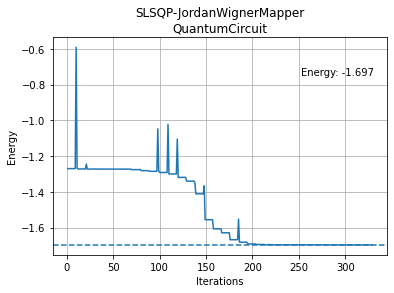

In [325]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']

energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.cost_function_evals,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.cost_function_evals,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f}).png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2o.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', 'rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', '# of qubits', '# of parameters', '# of CNOTs', '# of evaluations', 'error (mHa)']]

In [327]:
import decimal
print("f1", decimal.Decimal(1.205702e-10))
print("f2", decimal.Decimal(5.857791e+02))
print("f3", decimal.Decimal(1.245069e+00))
print("f4", decimal.Decimal(3.528289e-10))
print("f5", decimal.Decimal(4.147143e-04))
print("f5", decimal.Decimal(1.008598e-03))

f1 1.205701999999999896435675552481235628388134273336618207395076751708984375E-10
f2 585.779099999999971259967423975467681884765625
f3 1.24506899999999998129851519479416310787200927734375
f4 3.52828900000000022235038463552987166027552490277230390347540378570556640625E-10
f5 0.0004147142999999999944844841781588229423505254089832305908203125
f5 0.00100859800000000008994571754072921976330690085887908935546875


<div class="alert alert-block alert-danger">
    
<b>Tutorial questions 3</b> 

Experiment with all the parameters and answer the following:

1. Can you find an efficient heuristic ansatz? 
2. Which of the `UCCSD, PUCCD or SUCCD` ansatz is best? 
3. Which optimizer perform best with `UCCSD`? 

Remember, to find the most efficient ansatz you have to consider the accuracy, number of parameters and number of optimization steps, number of CNOTs. This is a discussion question and will not be graded. Feel free to discuss your answers in the Slack channel. 
</div>

## Part 2: qEOM for water molecule 


In this part, you will compute the excited states of the previously defined water molecule

To use the qEOM as a solver in Qiskit, we have to define a ground state calculation first. With this the qEOM solver can be initialized:

In [328]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import GroundStateEigensolver, QEOM, VQEUCCFactory

# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
solver = VQEUCCFactory(quantum_instance)
gsc = GroundStateEigensolver(converter, solver)

# The qEOM algorithm is simply instantiated with the chosen ground state solver
qeom_excited_states_calculation = QEOM(gsc, "sd")

qeom_results = qeom_excited_states_calculation.solve(problem)

print(qeom_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.700895930363
  - computed part:      -1.69700702885
  - ActiveSpaceTransformer extracted energy part: -83.003888901513
~ Nuclear repulsion energy (Hartree): 9.819476509782
> Total ground state energy (Hartree): -74.88141942058
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -84.276708397288
> Total excited state energy (Hartree): -74.457231887506
  2: 
* Electronic excited state energy (Hartree): -84.199633757776
> Total excited state energy (Hartree): -74.380157247994
  3: 
* Electronic excited state energy (Hartree): -83.506845228421
> Total excited state energy (Hartree): -73.687368718639
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.86710004  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [2.06496784  0.0  0.0]
    - computed part:      [0.00228274  0.0  0.0]

<div class="alert alert-block alert-danger">
    
<b>Tutorial questions 4</b> 

Obtain the exact excited states energies and compare with the ones obtained from qEOM. (Coding)

Post your thoughts on the observed differences in the Slack channel.
    
</div>

In [349]:
# WRITE YOUR CODE BETWEEN THESE LINES - START

from qiskit_nature.algorithms import ExcitedStatesEigensolver
from qiskit_nature.algorithms import NumPyEigensolverFactory
'''

# This solver does not return enough exited states. Used a filter below.

numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)
#solver = NumPyMinimumEigensolverFactory()

numpy_excited_states_calculation = ExcitedStatesEigensolver(converter, numpy_solver)
numpy_results = numpy_excited_states_calculation.solve(problem)

print(numpy_results)
print("\n\n")
'''

# Used a filter to filter more exited states

def filter_criterion(eigenstate, eigenvalue, aux_values):
    return np.isclose(aux_values[0][0], 2.0)

new_numpy_solver = NumPyEigensolverFactory(filter_criterion=filter_criterion)
new_numpy_excited_states_calculation = ExcitedStatesEigensolver(converter, new_numpy_solver)
new_numpy_results = new_numpy_excited_states_calculation.solve(problem)

print(qeom_results)
print("------------------------")
print(new_numpy_results)

print("1: Difference in excited energy classical - qEOM ", new_numpy_results.total_energies[0] - qeom_results.total_energies[0])
print("2: Difference in excited energy classical - qEOM ", new_numpy_results.total_energies[1] - qeom_results.total_energies[1])
print("3: Difference in excited energy classical - qEOM ", new_numpy_results.total_energies[2] - qeom_results.total_energies[2])
print("4: Difference in excited energy classical - qEOM ", new_numpy_results.total_energies[3] - qeom_results.total_energies[3])

# WRITE YOUR CODE BETWEEN THESE LINES - END

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.700895930363
  - computed part:      -1.69700702885
  - ActiveSpaceTransformer extracted energy part: -83.003888901513
~ Nuclear repulsion energy (Hartree): 9.819476509782
> Total ground state energy (Hartree): -74.88141942058
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -84.276708397288
> Total excited state energy (Hartree): -74.457231887506
  2: 
* Electronic excited state energy (Hartree): -84.199633757776
> Total excited state energy (Hartree): -74.380157247994
  3: 
* Electronic excited state energy (Hartree): -83.506845228421
> Total excited state energy (Hartree): -73.687368718639
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.86710004  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [2.06496784  0.0  0.0]
    - computed part:      [0.00228274  0.0  0.0]

## Additional information

**Created by:** Ieva Liepuoniute and Pauline Ollitrault

**Version:** qiskit-nature 0.3.2